## Prepare Data for ViT-based estimation method

used code in ViT-pytorch/

In [1]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path
import os, sys
import numpy as np
import torch
from tools.utils_at import *
from torch import Tensor
# from mmdet.models.utils import transform_tensors_to_list
# from mmdet.structures.bbox.transforms import bbox_cxcywh_to_xyxy, bbox_xyxy_to_cxcywh
# from mmdet.structures.bbox.bbox_overlaps import bbox_overlaps
from torchvision.ops.boxes import box_area
import torch.nn.functional as F

In [2]:
def bbox_overlaps(bboxes1, bboxes2, mode='iou', is_aligned=False, eps=1e-6):
    """Calculate overlap between two set of boxes.
    """

    assert mode in ['iou', 'iof', 'giou'], f'Unsupported mode {mode}'
    # Either the boxes are empty or the length of boxes' last dimension is 4
    assert (bboxes1.size(-1) == 4 or bboxes1.size(0) == 0)
    assert (bboxes2.size(-1) == 4 or bboxes2.size(0) == 0)

    # Batch dim must be the same
    # Batch dim: (B1, B2, ... Bn)
    assert bboxes1.shape[:-2] == bboxes2.shape[:-2]
    batch_shape = bboxes1.shape[:-2]

    rows = bboxes1.size(-2)
    cols = bboxes2.size(-2)
    if is_aligned:
        assert rows == cols

    if rows * cols == 0:
        if is_aligned:
            return bboxes1.new(batch_shape + (rows, ))
        else:
            return bboxes1.new(batch_shape + (rows, cols))

    area1 = (bboxes1[..., 2] - bboxes1[..., 0]) * (
        bboxes1[..., 3] - bboxes1[..., 1])
    area2 = (bboxes2[..., 2] - bboxes2[..., 0]) * (
        bboxes2[..., 3] - bboxes2[..., 1])

    if is_aligned:
        lt = torch.max(bboxes1[..., :2], bboxes2[..., :2])  # [B, rows, 2]
        rb = torch.min(bboxes1[..., 2:], bboxes2[..., 2:])  # [B, rows, 2]

        wh = fp16_clamp(rb - lt, min=0)
        overlap = wh[..., 0] * wh[..., 1]

        if mode in ['iou', 'giou']:
            union = area1 + area2 - overlap
        else:
            union = area1
        if mode == 'giou':
            enclosed_lt = torch.min(bboxes1[..., :2], bboxes2[..., :2])
            enclosed_rb = torch.max(bboxes1[..., 2:], bboxes2[..., 2:])
    else:
        lt = torch.max(bboxes1[..., :, None, :2],
                       bboxes2[..., None, :, :2])  # [B, rows, cols, 2]
        rb = torch.min(bboxes1[..., :, None, 2:],
                       bboxes2[..., None, :, 2:])  # [B, rows, cols, 2]

        wh = fp16_clamp(rb - lt, min=0)
        overlap = wh[..., 0] * wh[..., 1]

        if mode in ['iou', 'giou']:
            union = area1[..., None] + area2[..., None, :] - overlap
        else:
            union = area1[..., None]
        if mode == 'giou':
            enclosed_lt = torch.min(bboxes1[..., :, None, :2],
                                    bboxes2[..., None, :, :2])
            enclosed_rb = torch.max(bboxes1[..., :, None, 2:],
                                    bboxes2[..., None, :, 2:])

    eps = union.new_tensor([eps])
    union = torch.max(union, eps)
    ious = overlap / union
    if mode in ['iou', 'iof']:
        return ious
    # calculate gious
    enclose_wh = fp16_clamp(enclosed_rb - enclosed_lt, min=0)
    enclose_area = enclose_wh[..., 0] * enclose_wh[..., 1]
    enclose_area = torch.max(enclose_area, eps)
    gious = ious - (enclose_area - union) / enclose_area
    return gious
    
def bbox_xyxy_to_cxcywh(bbox: Tensor) -> Tensor:
    """Convert bbox coordinates from (x1, y1, x2, y2) to (cx, cy, w, h).

    Args:
        bbox (Tensor): Shape (n, 4) for bboxes.

    Returns:
        Tensor: Converted bboxes.
    """
    x1, y1, x2, y2 = bbox.split((1, 1, 1, 1), dim=-1)
    bbox_new = [(x1 + x2) / 2, (y1 + y2) / 2, (x2 - x1), (y2 - y1)]
    return torch.cat(bbox_new, dim=-1)
    
def bbox_cxcywh_to_xyxy(bbox: Tensor) -> Tensor:
    """Convert bbox coordinates from (cx, cy, w, h) to (x1, y1, x2, y2).

    Args:
        bbox (Tensor): Shape (n, 4) for bboxes.

    Returns:
        Tensor: Converted bboxes.
    """
    cx, cy, w, h = bbox.split((1, 1, 1, 1), dim=-1)
    bbox_new = [(cx - 0.5 * w), (cy - 0.5 * h), (cx + 0.5 * w), (cy + 0.5 * h)]
    return torch.cat(bbox_new, dim=-1)
    
def transform_tensor_to_list(l):
    return l.cpu().tolist()
    
def transform_tensors_to_list(l):
    if torch.is_tensor(l):
        return transform_tensor_to_list(l)
    if isinstance(l, list):
        r = []
        for i in l:
            r.append(transform_tensors_to_list(i))
        return r
    if isinstance(l, dict):
        r = {}
        for k,v in l.items():
            r[k] = transform_tensors_to_list(v)
        return r
    return l

In [3]:
# function
def box_iou(boxes1, boxes2):
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)


    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

    union = area1[:, None] + area2 - inter

    iou = inter / (union + 1e-6)
    return iou, union

def generalized_box_iou(boxes1, boxes2):
    """
    Generalized IoU from https://giou.stanford.edu/

    The boxes should be in [x0, y0, x1, y1] format

    Returns a [N, M] pairwise matrix, where N = len(boxes1)
    and M = len(boxes2)
    """
    # degenerate boxes gives inf / nan results
    # so do an early check
    assert (boxes1[:, 2:] >= boxes1[:, :2]).all()
    assert (boxes2[:, 2:] >= boxes2[:, :2]).all()

    iou, union = box_iou(boxes1, boxes2)

    lt = torch.min(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    area = wh[:, :, 0] * wh[:, :, 1]

    return iou - (area - union) / (area + 1e-6)
    
def hungarian_matching(out_logits, out_boxes, tgt_ids, tgt_bbox, cost_class_weight = 1.0, cost_bbox_weight = 5.0, cost_giou_weight = 2.0, focal_alpha = 0.25):
    """ Performs the matching
    """
    
    # We flatten to compute the cost matrices in a batch
    num_queries = out_logits.shape[0]
    out_prob = out_logits.softmax(dim=1)  # [num_queries, num_classes]
    
    # Compute the classification cost.
    alpha = focal_alpha
    gamma = 2.0
    neg_cost_class = (1 - alpha) * (out_prob ** gamma) * (-(1 - out_prob + 1e-8).log())
    pos_cost_class = alpha * ((1 - out_prob) ** gamma) * (-(out_prob + 1e-8).log())
    cost_class = pos_cost_class[:, tgt_ids] - neg_cost_class[:, tgt_ids]
    
    # Compute the L1 cost between boxes
    cost_bbox = torch.cdist(out_boxes, tgt_bbox, p=1)
    
    # Compute the giou cost betwen boxes            
    cost_giou = -generalized_box_iou(bbox_cxcywh_to_xyxy(out_boxes), bbox_cxcywh_to_xyxy(tgt_bbox))
    
    # Final cost matrix
    C = cost_bbox * cost_bbox_weight + cost_class * cost_class_weight + cost_giou * cost_giou_weight
    C = C.view(num_queries, -1)
    result = torch.argmin(C, axis=1)
    return result

def get_indexes(out_logits):
    prob = out_logits.softmax(dim=1)
    prob, _ = prob.max(dim=1)
    select_mask = prob > score_threshold
    if sum(select_mask) == 0:
        score, indexes = prob.topk(10)
        indexes,_ = torch.sort(indexes, dim=0)
        print(f"Cannot find detected objects with score larger than {score_threshold}")
    else:
        indexes = select_mask.nonzero().reshape(-1)
    return indexes

def get_topk_indexes(out_logits, k):
    k = min(k, out_logits.shape[0])
    prob = out_logits.softmax(dim=1)
    prob, _ = prob.max(dim=1)
    score, indexes = prob.topk(k)
    indexes,_ = torch.sort(indexes, dim=0)
    return indexes

def sigmoid_focal_loss(inputs, targets, alpha: float = 0.25, gamma: float = 2):
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples. Default = -1 (no weighting).
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
    Returns:
        Loss tensor
    """
    prob = inputs.sigmoid()
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = prob * targets + (1 - prob) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss
    return loss
    
def compute_loss(out_logits, out_boxes, tgt_ids, tgt_bbox, matched_target_indexes, cls_loss_coef = 1.0, bbox_loss_coef = 5.0, giou_loss_coef = 2.0):
    if matched_target_indexes == None:
        target_classes_onehot = torch.zeros([out_logits.shape[0], out_logits.shape[1]],dtype=out_logits.dtype, layout=out_logits.layout, 
                                        device=out_logits.device)
        loss_ce = sigmoid_focal_loss(out_logits, target_classes_onehot)
        loss_ce = loss_ce.sum(axis=1)
        loss = loss_ce * cls_loss_coef
        return loss, loss_ce, torch.zeros(loss.shape), torch.zeros(loss.shape)
    cls_loss_coef = 1.0
    bbox_loss_coef = 5.0
    giou_loss_coef = 2.0
    target_boxes = tgt_bbox[matched_target_indexes]
    loss_bbox = F.l1_loss(out_boxes, target_boxes, reduction='none') # [num_queries, 4]
    loss_bbox = loss_bbox.mean(axis=1) # [num_queries]
    loss_giou = 1 - torch.diag(generalized_box_iou(bbox_cxcywh_to_xyxy(out_boxes),
                bbox_cxcywh_to_xyxy(target_boxes))) # [num_queries]
    target_classes_onehot = torch.zeros([out_logits.shape[0], out_logits.shape[1]],dtype=out_logits.dtype, layout=out_logits.layout, 
                                        device=out_logits.device)
    target_labels = torch.tensor(tgt_ids)[matched_target_indexes]
    target_classes_onehot.scatter_(1, target_labels.unsqueeze(-1), 1)
    loss_ce = sigmoid_focal_loss(out_logits, target_classes_onehot)
    loss_ce = loss_ce.sum(axis=1)
    loss = loss_ce * cls_loss_coef + loss_bbox * bbox_loss_coef + loss_giou * giou_loss_coef
    return loss, loss_ce, loss_bbox, loss_giou

def generate_feature_annotation(num, count):
    file_path = data_path + str(num) + ".json"
    output_data = read_json_results(file_path)
    feature = np.array(output_data['feature'][5][0])
    out_logits = torch.FloatTensor(output_data['pred_logits'][5][0])
    out_boxes = torch.FloatTensor(output_data['pred_boxes'][5][0])
    target_labels = output_data['gt_labels']
    target_boxes = torch.FloatTensor(output_data['gt_boxes'])
    if len(target_boxes) == 0:
        return False
    target_boxes = bbox_xyxy_to_cxcywh(target_boxes)
    img_h, img_w = output_data['img_metas'][0]['img_shape']
    factors = output_data['img_metas'][0]['scale_factor']
    shapes = torch.FloatTensor([img_h, img_w, img_h, img_w])
    target_boxes = target_boxes / shapes
    out_logits = out_logits[:, 0:80] # for detr & coco
    indexes = get_indexes(out_logits)
    out_logits = out_logits[indexes]
    out_boxes = out_boxes[indexes]
    gt_indexes = hungarian_matching(out_logits, out_boxes, target_labels, target_boxes)
    loss, loss_ce, loss_bbox, loss_giou = compute_loss(out_logits, out_boxes, target_labels, target_boxes, gt_indexes)
    np_write(feature, feature_path + str(count) + ".npy")
    json_data = {}
    json_data['loss'] = transform_tensors_to_list(loss)
    json_data['loss_ce'] = transform_tensors_to_list(loss_ce)
    json_data['loss_bbox'] = transform_tensors_to_list(loss_bbox)
    json_data['loss_giou'] = transform_tensors_to_list(loss_giou)
    json_data['index'] = transform_tensors_to_list(indexes)
    json_data['gt_indexes'] = transform_tensors_to_list(gt_indexes)
    json_data['output_file_num'] = num
    write_json_results(json_data, annotation_path + str(count) + ".json")
    return True

In [103]:
split = "train"
base_path = "./pro_data/YOLOX_COCO/"
data_path = base_path + split + "/outputs/"
feature_path = base_path + split + "/feature/"
annotation_path = base_path + split + "/annotation/"
create_folder_if_not_exists(feature_path)
create_folder_if_not_exists(annotation_path)
score_threshold = 0.5 # DETR_COCO 0.98, DFDETR_COCO 0.5

### Generate image_true_losses and region_true_losses

In [104]:
files_in_folder = os.listdir(annotation_path)
nums = len(files_in_folder) - 1
img_loss = np.zeros(nums)
region_loss = []
for i in range(nums):
    path = annotation_path + str(i) + ".json"
    json_data = read_json_results(path)
    losses = np.array(json_data['loss'])
    img_loss[i] = losses.mean()
    region_loss.extend(json_data['loss'])
np_write(img_loss, base_path + split + "/image_true_losses.npy")
np_write(np.array(region_loss), base_path + split + "/region_true_losses.npy")

In [105]:
split = "train"
image_loss = np_read(base_path + split + "/image_true_losses.npy")
print(image_loss.min(), image_loss.max())
region_loss = np_read(base_path + split + "/region_true_losses.npy")
print(region_loss.min(), region_loss.max())

5.241252422332764 13.564805221557616
5.081507205963135 23.36237335205078


In [98]:
files_in_folder = os.listdir(annotation_path)
nums = len(files_in_folder) - 1
for i in range(1629,nums):
    path = annotation_path + str(i) + ".json"
    json_data = read_json_results(path)
    losses = np.array(json_data['loss'])
    find_index = losses < 1
    if find_index.sum() > 0:
        file_path = data_path + str(json_data['output_file_num']) + ".json"
        output_data = read_json_results(file_path)
        if len(output_data['gt_labels']) < 5:
            break

In [99]:
losses

array([4.06489944, 1.44735169, 1.33896017, 4.06633759, 1.69643831,
       4.01878357, 1.01745653, 3.27959204, 1.63278008, 2.60580635,
       1.2674818 , 2.80744076, 1.37766743, 4.03034687, 1.23242128,
       1.05928373, 1.99125504, 2.8250351 , 4.05047417, 4.02912712,
       1.53894591, 1.12572658, 4.05939579, 7.39889669, 4.02109814,
       4.01837206, 3.35164094, 1.74750412, 1.48347092, 3.312778  ,
       0.8911106 , 1.45261455, 3.39785624, 1.07145047, 3.33720684,
       3.42691231, 3.46321964, 1.74727488, 3.41578865, 1.24211073,
       4.08653879, 1.7955935 ])

In [100]:
path, np.array(json_data['gt_indexes']).shape

('./pro_data/DETR_COCO/val/annotation/1840.json', (42,))

In [92]:
np.array(json_data['gt_indexes'])[find_index]

array([[3]])

In [93]:
json_data['output_file_num']

1912

In [101]:
file_path = data_path + str(json_data['output_file_num']) + ".json"
output_data = read_json_results(file_path)
output_data['img_metas'], output_data['gt_labels']

([{'scale_factor': [1.3071895424836601, 1.3071895424836601],
   'pad_shape': [800, 800],
   'img_path': 'data/coco/val2017/000000489924.jpg',
   'batch_input_shape': [800, 800],
   'ori_shape': [612, 612],
   'img_shape': [800, 800],
   'img_id': 489924}],
 [0, 36])

In [102]:
output_data['gt_boxes']

[[83.41000366210938, 0.0, 545.3900146484375, 542.989990234375],
 [252.3800048828125, 431.4599914550781, 457.239990234375, 610.5800170898438]]

### Generate feature and annotation

In [ ]:
files_in_folder = os.listdir(data_path)
num_files = len(files_in_folder) - 1
count = 0
for num in range(num_files):
    flag = generate_feature_annotation(num, count)
    if flag:
        count += 1
    if (num+1)%1000 == 0:
        print(num)

# change feature and output size

In [ ]:
files_in_folder = os.listdir(data_path)
num_files = len(files_in_folder) - 1
for num in range(num_files):
    file_path = data_path + str(num) + ".json"
    output_data = read_json_results(file_path)
    feature = output_data['feature'][5][0]
    out_logits = output_data['pred_logits'][5][0]
    out_boxes = output_data['pred_boxes'][5][0]
    output_data['feature'] = feature
    output_data['pred_logits'] = out_logits
    output_data['pred_boxes'] = out_boxes
    write_json_results(output_data, file_path)
    if (num+1)%1000 == 0:
        print(num)

## demo

In [90]:
num = 100
file_path = data_path + str(num) + ".json"
output_data = read_json_results(file_path)

In [91]:
feature = np.array(output_data['feature'])
out_logits = torch.FloatTensor(output_data['pred_logits'])
out_boxes = torch.FloatTensor(output_data['pred_boxes'])
out_logits = out_logits[:, 0:80] # for detr & coco

In [92]:
selected_indexes = get_topk_indexes(out_logits, 198)

In [93]:
feature = feature[selected_indexes]
out_logits = out_logits[selected_indexes]
out_boxes = out_boxes[selected_indexes]

In [94]:
score_threshold = 0.4
prob = out_logits.softmax(dim=1)
prob, _ = prob.max(dim=1)
sum(prob > score_threshold)

tensor(4)

In [95]:
output_data['img_metas']

[{'img_path': 'data/coco/val2017/000000551215.jpg',
  'pad_shape': [1067, 800],
  'ori_shape': [640, 480],
  'scale_factor': [1.6666666666666667, 1.6671875],
  'batch_input_shape': [1067, 800],
  'img_id': 551215,
  'img_shape': [1067, 800]}]

In [96]:
len(output_data['gt_labels'])

2

In [9]:
target_labels = output_data['gt_labels']
target_boxes = torch.FloatTensor(output_data['gt_boxes'])
if len(target_boxes) > 0:
    target_boxes = bbox_xyxy_to_cxcywh(target_boxes)
img_h, img_w = output_data['img_metas'][0]['img_shape']
factors = output_data['img_metas'][0]['scale_factor']
shapes = torch.FloatTensor([img_h, img_w, img_h, img_w])
target_boxes = target_boxes / shapes
# out_logits = out_logits[:, 0:80] # for detr & coco
indexes = get_indexes(out_logits)
out_logits = out_logits[indexes]
out_boxes = out_boxes[indexes]
gt_indexes = hungarian_matching(out_logits, out_boxes, target_labels, target_boxes)
loss, loss_ce, loss_bbox, loss_giou = compute_loss(out_logits, out_boxes, target_labels, target_boxes, gt_indexes)

In [50]:
np_write(feature, feature_path + str(num) + ".npy")
json_data = {}
json_data['loss'] = transform_tensors_to_list(loss)
json_data['loss_ce'] = transform_tensors_to_list(loss_ce)
json_data['loss_bbox'] = transform_tensors_to_list(loss_bbox)
json_data['loss_giou'] = transform_tensors_to_list(loss_giou)
json_data['index'] = transform_tensors_to_list(indexes)
json_data['gt_indexes'] = transform_tensors_to_list(gt_indexes)
json_data['output_file_num'] = num
json_data['img_metas'] = output_data['img_metas']
write_json_results(json_data, annotation_path + str(num) + ".json")

In [67]:
json = read_json_results(base_path + "train" + "/annotation/" + "55397.json")

In [68]:
json['output_file_num']

55894

In [60]:
patch_loss = torch.tensor(json['loss'])
img_loss = patch_loss.mean()
patch_index = torch.tensor(json['index'])
annotation = torch.full((100,), 255, dtype=patch_loss.dtype)
annotation[patch_index] = patch_loss

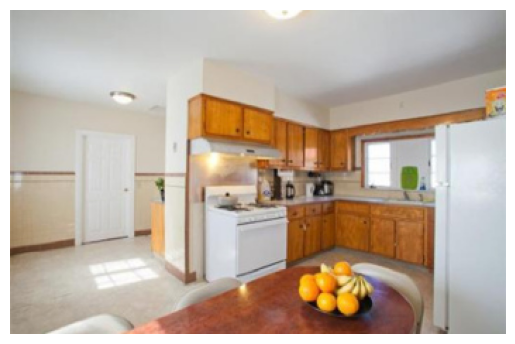

In [58]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read the PNG image
img = mpimg.imread('./data/coco/val2017/000000037777.jpg')  # Replace 'your_image.png' with the path to your PNG image

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()